In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarscov/Virat-4.jpg
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (501).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (1031).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (534).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (634).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (1207).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (385).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (725).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (243).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (1132).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (413).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (354).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (31).png
/kaggle/input/sarscov/Covid_new_data/test/non-COVID/Non-Covid (1208).png
/kaggle/input/sarscov/Covid

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import *
import tensorflow as tf

In [3]:
image_width=224
image_height=224
no_of_channels=3
input_shape=(image_width,image_height,no_of_channels)

In [4]:
#FEEDING DATA INTO THE MODEL
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#class for training set
train_data = ImageDataGenerator(rescale = 1./255)

#class for test set
test_data = ImageDataGenerator(rescale = 1./255)


train_data_dir = '../input/sarscov/Covid_new_data/train'
test_data_dir = '../input/sarscov/Covid_new_data/test'
batch_size = 32

train_set = train_data.flow_from_directory(train_data_dir, #Image path
                                           target_size = (224,224), #The shape which we want to input our images in our model
                                           batch_size = batch_size,         #The batch size in mini batch gradient descent
                                           class_mode = 'categorical', shuffle=True) 
test_set = test_data.flow_from_directory(test_data_dir, #Image path
                                           target_size = (224,224), #The shape which we want to input our images in our model
                                           batch_size = batch_size,         #The batch size in mini batch gradient descent
                                           class_mode = 'categorical', shuffle=False)  

Found 1984 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [5]:
COUNT_TRAIN_COVID = len(os.listdir('../input/sarscov/Covid_new_data/train/COVID'))
COUNT_TRAIN_NONCOVID = len(os.listdir('../input/sarscov/Covid_new_data/train/non-COVID'))
TRAIN_IMG_COUNT = COUNT_TRAIN_NONCOVID + COUNT_TRAIN_COVID
print('Train images: ',TRAIN_IMG_COUNT)
initial_bias = np.log([COUNT_TRAIN_COVID/COUNT_TRAIN_NONCOVID])
print(initial_bias)

weight_for_0 = (1 / COUNT_TRAIN_COVID)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_TRAIN_NONCOVID)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Train images:  1984
[0.01814566]
Weight for class 0: 0.99
Weight for class 1: 1.01


In [6]:
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=5,
                                         cooldown=2,
                                         min_lr=1e-8,
                                         verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

#EPOCHS = 100
EPOCHS = 50

In [7]:
#VGG-16 MODEL NO. 1
#from tensorflow.keras.applications import VGG16
tmodel_base = VGG16(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#Getting desired layer output
last_layer = tmodel_base.get_layer('block5_pool')
last = last_layer.output

x = Flatten()(last)
x = Dense(1028, activation = 'relu')(x)
x = Dropout(rate = 0.15)(x)
x = Dense(512, activation = 'relu')(x)
#x = Dropout(rate = 0.25)(x)
x = Dropout(rate = 0.2)(x)
x = Dense(2, activation = 'softmax')(x)
# Modification of pretrained mode

#Compiling model
model1 = Model(inputs = tmodel_base.input, outputs = x, name = 'VGG16')
opt1 = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
#opt2 = RMSprop(learning_rate = 0.001)


model1.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model1.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [8]:
# Fits the model on batches with real-time data augmentation
vgg_checkpoint = ModelCheckpoint("vgg_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

history_vgg = model1.fit(train_set,  epochs=EPOCHS, validation_data = test_set
                       ,class_weight=class_weight ,callbacks=[vgg_checkpoint])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.7359
Epoch 00001: val_loss improved from inf to 0.35241, saving model to vgg_best.h5
62/62 [==============================] - 31s 496ms/step - loss: 0.5311 - accuracy: 0.7359 - val_loss: 0.3524 - val_accuracy: 0.8712
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8684
Epoch 00002: val_loss improved from 0.35241 to 0.26171, saving model to vgg_best.h5
62/62 [==============================] - 16s 254ms/step - loss: 0.3385 - accuracy: 0.8684 - val_loss: 0.2617 - val_accuracy: 0.9034
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.8926
Epoch 00003: val_loss improved from 0.26171 to 0.22212, saving model to vgg_best.h5
62/62 [==============================] - 15s 244ms/step - loss: 0.2739 - accuracy: 0.8926 - val_loss: 0.2221 - val_accuracy: 0.9256
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 0.2112

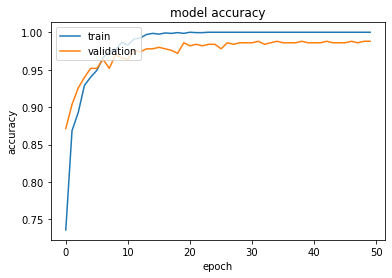

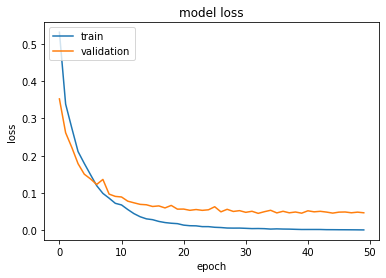

In [9]:
#  "Accuracy"
history1 = history_vgg
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
#Xception MODEL NO. 1
#from tensorflow.keras.applications import Xception
tmodel_base = Xception(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#Getting desired layer output
# Modification of pretrained model
last_layer = tmodel_base.get_layer('block14_sepconv2_act')
last_output = last_layer.output
 
#x = GlobalMaxPooling2D()(last_output)
x = MaxPooling2D(strides=(2,2))(last_output)
x = Flatten()(x)
#x = Dense(1024,activation='relu')(x)
#x = Dropout(0.15)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(2, activation='softmax')(x)
#Compiling model
model2 = Model(inputs = tmodel_base.input, outputs = x, name = 'Our_Xception')
model2.summary()


83689472/83683744 [==============================] - 2s 0us/step
Model: "Our_Xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________

In [11]:
opt1 = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999)
#opt2 = RMSprop(learning_rate = 0.001)
xception_checkpoint = ModelCheckpoint("xception_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

model2.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])

history2 = model2.fit(train_set, epochs=EPOCHS, validation_data = test_set
                     ,class_weight=class_weight ,callbacks=[ xception_checkpoint])

Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.6442
Epoch 00001: val_loss improved from inf to 0.47230, saving model to xception_best.h5
62/62 [==============================] - 16s 252ms/step - loss: 0.6485 - accuracy: 0.6442 - val_loss: 0.4723 - val_accuracy: 0.7686
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.4784 - accuracy: 0.7782
Epoch 00002: val_loss improved from 0.47230 to 0.38857, saving model to xception_best.h5
62/62 [==============================] - 15s 238ms/step - loss: 0.4784 - accuracy: 0.7782 - val_loss: 0.3886 - val_accuracy: 0.8330
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.3804 - accuracy: 0.8372
Epoch 00003: val_loss improved from 0.38857 to 0.33796, saving model to xception_best.h5
62/62 [==============================] - 15s 241ms/step - loss: 0.3804 - accuracy: 0.8372 - val_loss: 0.3380 - val_accuracy: 0.8511
Epoch 4/50
62/62 [==============================] - ETA: 0s

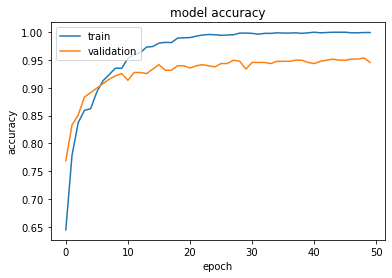

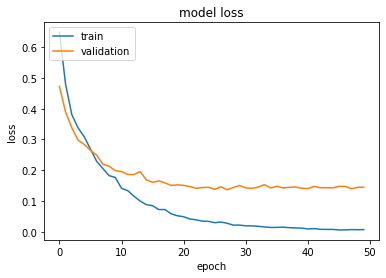

In [12]:
#  "Accuracy"
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
#ResNet50 MODEL NO. 3
from tensorflow.keras.applications.resnet50 import ResNet50
num_classes=1
tmodel_base = ResNet50(input_shape = input_shape, 
                                include_top = False, 
                                weights = 'imagenet')
for layer in tmodel_base.layers:
    layer.trainable = False

#last_layer = tmodel_base.get_layer('flatten_13')
last = tmodel_base.output


x = Conv2D(1024,(2,2),strides=(1,1))(last)
#x = layers.GlobalMaxPooling2D()(last)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(rate = 0.15)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = 0.25)(x)
x = Dense(2, activation = 'softmax')(x)

#Compiling model
model3 = Model(inputs = tmodel_base.input, outputs = x)
model3.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________

In [14]:
opt1 = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999)
#opt2 = RMSprop(learning_rate = 0.001)
resnet_checkpoint = ModelCheckpoint("resnetbest.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

model3.compile(optimizer = opt1 , loss = 'categorical_crossentropy', metrics = ['accuracy'])
history3 = model3.fit(train_set,epochs=EPOCHS, validation_data = test_set
                      ,class_weight=class_weight ,callbacks=[resnet_checkpoint])


Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 1.1719 - accuracy: 0.5464
Epoch 00001: val_loss improved from inf to 0.71211, saving model to resnetbest.h5
62/62 [==============================] - 17s 266ms/step - loss: 1.1719 - accuracy: 0.5464 - val_loss: 0.7121 - val_accuracy: 0.4970
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.6466 - accuracy: 0.6310
Epoch 00002: val_loss improved from 0.71211 to 0.59080, saving model to resnetbest.h5
62/62 [==============================] - 15s 245ms/step - loss: 0.6466 - accuracy: 0.6310 - val_loss: 0.5908 - val_accuracy: 0.6700
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.5873 - accuracy: 0.6835
Epoch 00003: val_loss improved from 0.59080 to 0.47203, saving model to resnetbest.h5
62/62 [==============================] - 15s 246ms/step - loss: 0.5873 - accuracy: 0.6835 - val_loss: 0.4720 - val_accuracy: 0.7767
Epoch 4/50
62/62 [==============================] - ETA: 0s - loss: 

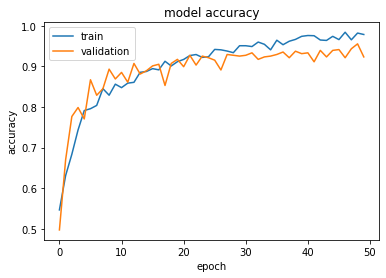

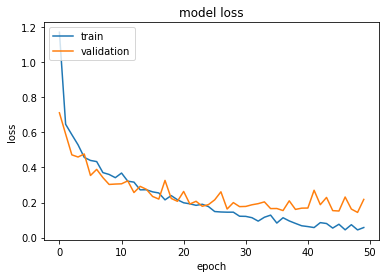

In [15]:
#  "Accuracy"
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Ensemble**
--

This is for redrawing the graphs ( ROC curves)

In [16]:
our_vgg = tf.keras.models.load_model('../input/finalnotebook/vgg_best.h5')
our_xcep = tf.keras.models.load_model('../input/finalnotebook/xception_best.h5')
our_resnet = tf.keras.models.load_model('../input/finalnotebook/resnetbest.h5')


print(our_vgg.evaluate(test_set))
print(our_xcep.evaluate(test_set))
print(our_resnet.evaluate(test_set))

OSError: SavedModel file does not exist at: ../input/finalnotebook/vgg_best.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
our_vgg.trainable = False
our_resnet.trainable = False
our_xcep.trainable = False

In [ ]:
def stacking_ensemble(members,input_shape,n_classes):
    commonInput = Input(shape=input_shape)
    out=[]

    for model in members:    
       #model._name= model._name+"test"+ str(members.index(model)+1)
        model._name= model.get_layer(index = 0)._name +"-test"+ str(members.index(model)+1)
        out.append(model(commonInput))

    modeltmp = concatenate(out,axis=-1)
    modeltmp = Dense(64, activation='relu')(modeltmp)
    #modeltmp = Dense(128, activation='relu')(modeltmp)
    modeltmp = Dense(n_classes, activation='softmax')(modeltmp)
    stacked_model = Model(commonInput,modeltmp)
    stacked_model.compile( loss='categorical_crossentropy',optimizer= optimizer, metrics=['accuracy'])

    return stacked_model


In [ ]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                       patience=4,
                                         cooldown=2,
                                         min_lr=1e-8,
                                         verbose=1)


**VGG16 + ResNet50**
--

In [ ]:
members =[our_vgg, our_resnet]

n_classes=2
epochs= 100
batch=32
optimizer= Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)

vgg_res = stacking_ensemble(members,(image_height,image_width,3),n_classes)

In [ ]:
#generator=MultipleInputGenerator(X_train,X_train,y_train,batch)
vgg_res_checkpoint = ModelCheckpoint("vgg_res_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

vgg_res_hist = vgg_res.fit(train_set,
                            epochs=100, #epochs,
                            verbose=1,
                            validation_data= test_set,
                            class_weight = class_weight,
                            callbacks=[reduce_learning_rate, vgg_res_checkpoint]) #

In [ ]:
#  "Accuracy"
plt.plot(vgg_res_hist.history['accuracy'])
plt.plot(vgg_res_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(vgg_res_hist.history['loss'])
plt.plot(vgg_res_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**VGG16 + Xception**
--

In [ ]:
members =[our_vgg, our_xcep]

n_classes=2
epochs= 100
batch=32
optimizer= Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)

vgg_xcep = stacking_ensemble(members,(image_height,image_width,3),n_classes)


In [ ]:
#generator=MultipleInputGenerator(X_train,X_train,y_train,batch)
vgg_xcep_checkpoint = ModelCheckpoint("vgg_xcep_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

vgg_xcep_hist = vgg_xcep.fit(train_set,
                            epochs=100, #epochs,
                            verbose=1,
                            validation_data= test_set,
                            class_weight = class_weight,
                            callbacks=[reduce_learning_rate, vgg_xcep_checkpoint]) #

In [ ]:
#  "Accuracy"
plt.plot(vgg_xcep_hist.history['accuracy'])
plt.plot(vgg_xcep_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(vgg_xcep_hist.history['loss'])
plt.plot(vgg_xcep_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


**ResNet50 + Xception**
--

In [ ]:
members =[our_resnet, our_xcep]

n_classes=2
epochs= 100
batch=32
optimizer= Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)

xcep_res = stacking_ensemble(members,(image_height,image_width,3),n_classes)

In [ ]:
#generator=MultipleInputGenerator(X_train,X_train,y_train,batch)
xcep_res_checkpoint = ModelCheckpoint("xcep_res_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

xcep_res_hist = xcep_res.fit(train_set,
                            epochs=100, #epochs,
                            verbose=1,
                            validation_data= test_set,
                            class_weight = class_weight,
                            callbacks=[reduce_learning_rate, xcep_res_checkpoint]) 


In [ ]:
#  "Accuracy"
plt.plot(xcep_res_hist.history['accuracy'])
plt.plot(xcep_res_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(xcep_res_hist.history['loss'])
plt.plot(xcep_res_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Stacked Model**
--

In [ ]:
members =[our_vgg, our_resnet,our_xcep]

n_classes=2
epochs= 100
batch=32
optimizer= Adam(lr=5e-5, beta_1=0.9, beta_2=0.999)

stacked_model = stacking_ensemble(members,(image_height,image_width,3),n_classes)


In [ ]:
#generator=MultipleInputGenerator(X_train,X_train,y_train,batch)
stacked_checkpoint = ModelCheckpoint("stacked_best.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto', period=1)


history = stacked_model.fit(train_set,
                            epochs=EPOCHS, #epochs,
                            verbose=1,
                            validation_data=test_set,
                            class_weight = class_weight,
                            callbacks=[reduce_learning_rate, stacked_checkpoint]) #

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Calculation**
--

In [ ]:
y_true = test_set.classes

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix

**VGG16**
--

In [ ]:
evaluation_vgg = our_vgg.evaluate(test_set)
print('Loss: ',evaluation_vgg[0])
print('Accuracy: ',evaluation_vgg[1])

prob_vgg = our_vgg.predict(test_set)
predictions_vgg = prob_vgg.argmax(axis=-1)

print("Precision, Recall and F1 Score:")
print(precision_recall_fscore_support(y_true, predictions_vgg, average='micro'))

fpr_vgg, tpr_vgg, thresholds_vgg = roc_curve(y_true, predictions_vgg)
auc_vgg = auc(fpr_vgg, tpr_vgg)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg, tpr_vgg, label='VGG16 (area = {:.3f})'.format(auc_vgg))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_vgg), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_vgg, target_names=target_names))

**ResNet50**
--

In [ ]:
evaluation_res = our_resnet.evaluate(test_set)
print('Loss: ',evaluation_res[0])
print('Accuracy: ',evaluation_res[1])


prob_res = our_resnet.predict(test_set)
predictions_res = prob_res.argmax(axis=-1)
print(precision_recall_fscore_support(y_true, predictions_res, average='micro'))


fpr_res, tpr_res, thresholds_res = roc_curve(y_true, predictions_res)
auc_res = auc(fpr_res, tpr_res)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_res, tpr_res, label='ResNet50 (area = {:.3f})'.format(auc_res))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_res), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_res, target_names=target_names))


**Xception**
--

In [ ]:
evaluation_xcep = our_xcep.evaluate(test_set)
print('Loss: ',evaluation_xcep[0])
print('Accuracy: ',evaluation_xcep[1])


prob_xcep = our_xcep.predict(test_set)
predictions_xcep = prob_xcep.argmax(axis=-1)
precision_recall_fscore_support(y_true, predictions_xcep, average='micro')


fpr_xcep, tpr_xcep ,thresholds_xcep = roc_curve(y_true, predictions_xcep)
auc_xcep = auc(fpr_xcep, tpr_xcep)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xcep, tpr_xcep, label='Xception (area = {:.3f})'.format(auc_xcep))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


print(pd.DataFrame(data = confusion_matrix(y_true, predictions_xcep), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_xcep, target_names=target_names))

**VGG16 + ResNet50**
--

In [ ]:
vgg_res = tf.keras.models.load_model('../input/finalnotebook/vgg_res_best.h5')

evaluation_vgg_res = vgg_res.evaluate(test_set)
print('Loss: ',evaluation_vgg_res[0])
print('Accuracy: ',evaluation_vgg_res[1])


prob_vgg_res = vgg_res.predict(test_set)
predictions_vgg_res = prob_vgg_res.argmax(axis=-1)
precision_recall_fscore_support(y_true, predictions_vgg_res, average='micro')


fpr_vgg_res, tpr_vgg_res, thresholds_vgg_res = roc_curve(y_true, predictions_vgg_res)
auc_vgg_res = auc(fpr_vgg_res, tpr_vgg_res)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg_res, tpr_vgg_res, label='vgg_res (area = {:.3f})'.format(auc_vgg_res))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


print(pd.DataFrame(data = confusion_matrix(y_true, predictions_vgg_res), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_vgg_res, target_names=target_names))


**VGG16 + Xception**
--

In [ ]:
vgg_xcep = tf.keras.models.load_model('../input/finalnotebook/vgg_xcep_best.h5')

evaluation_vgg_xcep = vgg_xcep.evaluate(test_set)
print('Loss: ',evaluation_vgg_xcep[0])
print('Accuracy: ',evaluation_vgg_xcep[1])

prob_vgg_xcep = vgg_xcep.predict(test_set)
predictions_vgg_xcep = prob_vgg_xcep.argmax(axis=-1)
print(precision_recall_fscore_support(y_true, predictions_vgg_xcep, average='micro'))

fpr_vgg_xcep, tpr_vgg_xcep, thresholds_vgg_xcep = roc_curve(y_true, predictions_vgg_xcep)
auc_vgg_xcep = auc(fpr_vgg_xcep, tpr_vgg_xcep)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg_xcep, tpr_vgg_xcep, label='vgg_xcep (area = {:.3f})'.format(auc_vgg_xcep))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_vgg_xcep), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_vgg_xcep, target_names=target_names))

**Xception + ResNet50**
--

In [ ]:
res_xcep = tf.keras.models.load_model('../input/finalnotebook/xcep_res_best.h5')

evaluation_res_xcep = res_xcep.evaluate(test_set)
print('Loss: ',evaluation_res_xcep[0])
print('Accuracy: ',evaluation_res_xcep[1])

prob_res_xcep = res_xcep.predict(test_set)
predictions_res_xcep = prob_res_xcep.argmax(axis=-1)
precision_recall_fscore_support(y_true, predictions_res_xcep, average='micro')

fpr_res_xcep, tpr_res_xcep, thresholds_res_xcep = roc_curve(y_true, predictions_res_xcep)
auc_res_xcep = auc(fpr_res_xcep, tpr_res_xcep)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_res_xcep, tpr_res_xcep, label='res_xcep(area = {:.3f})'.format(auc_res_xcep))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_res_xcep), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_res_xcep, target_names=target_names))



**Stacked(VGG16 + ResNet50 + Xception)**
--

In [ ]:
stacked = tf.keras.models.load_model('../input/finalnotebook/stacked_best.h5')

evaluation_stacked = stacked.evaluate(test_set)
print('Loss: ',evaluation_stacked[0])
print('Accuracy: ',evaluation_stacked[1])

prob_stacked = stacked.predict(test_set)
predictions_stacked = prob_stacked.argmax(axis=-1)
precision_recall_fscore_support(y_true, predictions_stacked, average='micro')

fpr_stacked, tpr_stacked, thresholds_stacked = roc_curve(y_true, predictions_stacked)
auc_stacked = auc(fpr_stacked, tpr_stacked)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_stacked, tpr_stacked, label='stacked(area = {:.3f})'.format(auc_stacked))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(pd.DataFrame(data = confusion_matrix(y_true, predictions_stacked), index = ['covid', 'non-covid'], columns = ['covid', 'non-covid'] ))
print('Classification Report')
target_names = ['Covid', 'Non-covid']
print(classification_report(y_true, predictions_stacked, target_names=target_names))

**ROC of Stacked vs Individuals**
--

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg, tpr_vgg, label='VGG16 (area = {:.3f})'.format(auc_vgg))
plt.plot(fpr_res, tpr_res, label='ResNet50 (area = {:.3f})'.format(auc_res))
plt.plot(fpr_xcep, tpr_xcep, label='Xception (area = {:.3f})'.format(auc_xcep))
#plt.plot(fpr_stacked, tpr_stacked, label='Stacked (area = {:.3f})'.format(auc_stacked))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**ROC of Ensembles**
--

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_stacked, tpr_stacked, label='VGG16+ResNet50+Xception(area = {:.3f})'.format(auc_stacked))
plt.plot(fpr_res_xcep, tpr_res_xcep, label='ResNet50 + Xception(area = {:.3f})'.format(auc_res_xcep))
plt.plot(fpr_vgg_xcep, tpr_vgg_xcep, label='VGG16 + Xception(area = {:.3f})'.format(auc_vgg_xcep))
plt.plot(fpr_vgg_res, tpr_vgg_res, label='VGG16 + ResNet50(area = {:.3f})'.format(auc_vgg_res))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

One more thing. Here you will find an image of Virat Kohli. Ignore it, it will not create any problem in anywhere. It was uploaded mistakenly. All the images inside the sub-folders of the folder train and test are CT images which are collected from the Kaggle SARSCOV2 dataset. And that images are randomly divided into two folder train and test using python laguage.
Here is the link of that original dataset: https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset

So, thank you. 